<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/experimental/ML_model(Resampling).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install pandas-ta==0.2.45b

In [2]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import pandas_ta as ta
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,f1_score
import datetime as dt

In [288]:
tickr='^nsei'
days_out=14
p_movement=2

In [343]:
nifty = yf.download(tickr,start='2016-01-01',end='2020-12-31')

[*********************100%***********************]  1 of 1 completed


In [344]:
nifty.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-29,13910.349609,13967.599609,13859.900391,13932.599609,13932.599609,439600
2020-12-30,13980.900391,13997.000000,13864.950195,13981.950195,13981.950195,380700


In [345]:
nifty['close_2%']=np.abs(nifty['Adj Close'].pct_change()*100).fillna(0)

In [346]:
test=pd.DataFrame(data=nifty['close_2%'].values,columns=['sum'])

In [347]:
nifty['cumsum']=0
nifty=nifty.reset_index()

In [348]:
for index , val in enumerate(nifty['close_2%']):
  
  if index==0:
    nifty.loc[index,'cumsum']=val
  else:
    if nifty['cumsum'].iloc[index-1]>p_movement:
      nifty.loc[index,'cumsum']=val
    else:
      nifty.loc[index, 'cumsum']=val+nifty['cumsum'].iloc[index-1]    

In [349]:
#test_f=pd.DataFrame({'Date':nifty.index, 'sum':test['cumsum'].values})
#pd.DataFrame({'Date':df.index,'spread':(df['Adj Close'].values - mean)})

In [350]:
nifty['diff']=nifty['close_2%']-nifty['cumsum']

In [351]:
nifty[['Close','close_2%','cumsum','diff']]

,Close,close_2%,cumsum,diff
0,7791.299805,0.000000,0.000000,0.000000
1,7784.649902,0.085350,0.085350,0.000000
2,7741.000000,0.560718,0.646068,-0.085350
3,7568.299805,2.230980,2.877048,-0.646068
4,7601.350098,0.436694,0.436694,0.000000
...,...,...,...,...
1222,13601.099609,1.001016,2.035644,-1.034628
1223,13749.250000,1.089253,1.089253,0.000000
1224,13873.200195,0.901505,1.990758,-1.089253
1225,13932.599609,0.428159,2.418918,-1.990758


In [352]:
final_data=nifty.iloc[nifty[nifty['diff']==0].index-1][1:]

In [353]:
final_data['Signal_Flag'] = final_data['Close'].transform(lambda x : np.sign(x.diff(days_out)))

In [354]:
final_data=final_data.dropna()

In [355]:
final_data.Signal_Flag.value_counts()

 1.0    234
-1.0     83
Name: Signal_Flag, dtype: int64

# Features Creation 

In [356]:
final_data=final_data.reset_index(drop=True)

In [357]:
final_data.ta.macd(append=True)
final_data.ta.vortex(append=True)
final_data.ta.aroon(append=True)
final_data.ta.mom(append=True)
final_data.ta.stdev(append=True)
final_data.ta.linreg(append=True)
final_data['spread']=final_data['LR_14']-final_data['close']
print()

In [358]:
final_data['date']=final_data['date'].map(dt.datetime.toordinal)

In [359]:
final_data=final_data.dropna()

In [360]:
features=final_data.columns.tolist()

In [361]:
features=[feats for feats in features if feats not in ['Signal_Flag']]

In [362]:
X=final_data[features]
y=final_data['Signal_Flag']

In [363]:
chk='Timeseries'

# and Modelling Part remaining

In [364]:
from sklearn.model_selection import TimeSeriesSplit

if chk=='Block':
  tscv = BlockingTimeSeriesSplit(n_splits=10)

  for fold, (train_index, test_index) in enumerate(tscv.split(X)):
      print("Fold: {}".format(fold))
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]
elif chk=='Timeseries':
  tscv = TimeSeriesSplit(n_splits=15)
  for fold, (train_index, test_index) in enumerate(tscv.split(X)):
      print("Fold: {}".format(fold))
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Fold: 10
Fold: 11
Fold: 12
Fold: 13
Fold: 14


In [365]:
for train_index, test_index in tscv.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [366]:
rand_frst_clf = RandomForestClassifier(n_estimators =220,max_depth=35,min_samples_leaf=14,max_features = "auto",min_samples_split=40, criterion = "gini", bootstrap=True,random_state = 42)


In [367]:
# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=35, min_samples_leaf=14, min_samples_split=40,
                       n_estimators=220, random_state=42)

In [368]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp*100
feats=X_train.columns
feature_imp

AROONU_14        0.201239
VTXM_14          0.174398
VTXP_14          0.156060
AROONOSC_14      0.134193
AROOND_14        0.088388
MACDh_12_26_9    0.087642
MOM_10           0.067953
MACD_12_26_9     0.029999
diff             0.009180
open             0.008696
LR_14            0.007360
MACDs_12_26_9    0.007153
low              0.006078
close            0.004980
high             0.004276
adj_close        0.004156
close_2%         0.003038
spread           0.002755
date             0.001147
cumsum           0.000494
STDEV_30         0.000443
volume           0.000373
dtype: float64

In [369]:
#y_pd= rand_frst_clf.predict(X_train)

In [370]:
# Make predictions
y_pred = rand_frst_clf.predict(X_test)

In [371]:
timeseries=pd.concat([X_test['adj_close'].reset_index(),pd.Series(y_pred)],axis=1)

In [372]:
timeseries.columns=['index','close','prediction']

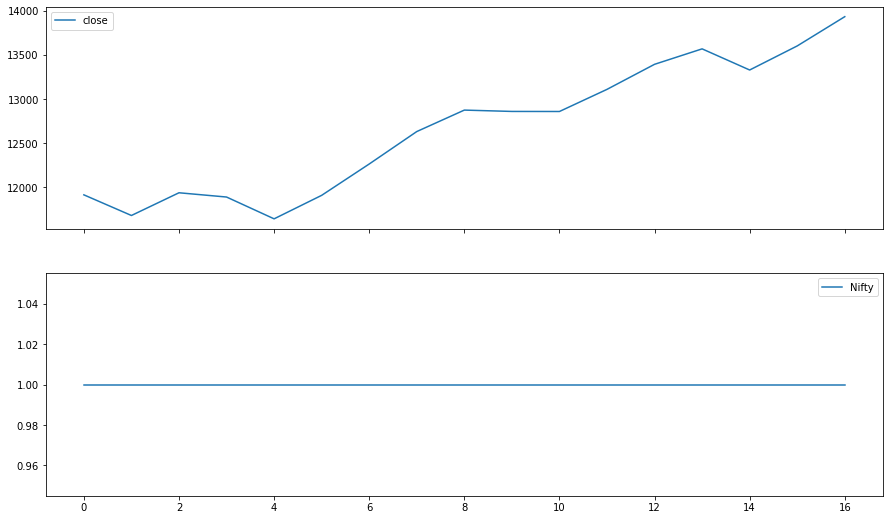

In [373]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1, figsize=(15,9),sharex=True)
ax[0].plot(timeseries.loc[:, :].index, timeseries.loc[:, 'close'], label='close')
ax[1].plot(timeseries.loc[:, :].index, timeseries.loc[:, 'prediction'], label='Nifty')
ax[0].legend()
ax[1].legend()
plt.show()

In [374]:
data_for_testing=yf.download(tickr,start='2019-01-01',parse_dates=['Date']).reset_index()

[*********************100%***********************]  1 of 1 completed


In [375]:
data_for_testing['Date']=data_for_testing['Date'].map(dt.datetime.toordinal)

In [376]:
data_for_testing['close_2%']=np.abs(data_for_testing['Adj Close'].pct_change()*100).fillna(0)

In [377]:
test_data=pd.DataFrame(data=data_for_testing['close_2%'].values,columns=['sum'])

In [378]:
data_for_testing['cumsum']=0

In [379]:
for index , val in enumerate(data_for_testing['close_2%']):
  
  if index==0:
    data_for_testing.loc[index,'cumsum']=val
  else:
    if data_for_testing['cumsum'].iloc[index-1]>p_movement:
      data_for_testing.loc[index,'cumsum']=val
    else:
      data_for_testing.loc[index, 'cumsum']=val+data_for_testing['cumsum'].iloc[index-1]

In [380]:
data_for_testing['diff']=data_for_testing['close_2%']-data_for_testing['cumsum']

In [381]:
final_test_data=data_for_testing.iloc[data_for_testing[data_for_testing['diff']==0].index-1][1:]

In [382]:
final_test_data.ta.macd(append=True)
final_test_data.ta.vortex(append=True)
final_test_data.ta.aroon(append=True)
final_test_data.ta.mom(append=True)
final_test_data.ta.stdev(append=True)
final_test_data.ta.linreg(append=True)
final_test_data['spread']=final_test_data['LR_14']-final_test_data['close']
print()

In [383]:
final_test_data['Signal_Flag'] = final_test_data['close'].transform(lambda x : np.sign(x.diff(days_out)))

In [384]:
final_test_data=final_test_data.dropna()

In [385]:
predict=rand_frst_clf.predict(final_test_data[features])

In [386]:
timeseries=pd.concat([final_test_data['adj_close'].dropna()[-len(predict):].reset_index(),pd.Series(predict)],axis=1)

In [387]:
timeseries.columns=['index','adj_close','predict']

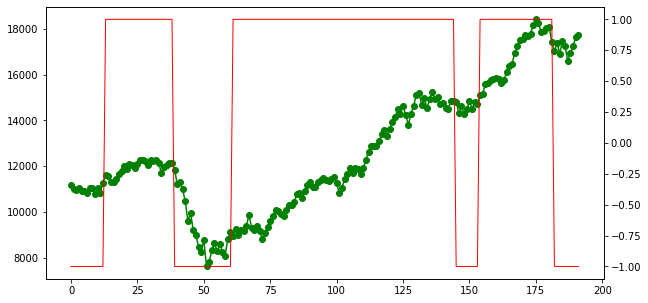

In [388]:
fig, ax = plt.subplots(figsize=(10,5),sharex=True)
ax.plot(timeseries.loc[:, :].index, timeseries.loc[:, 'adj_close'], label='Nifty',color='g',marker='o')
ax2=ax.twinx()
ax2.plot(timeseries.loc[:, :].index, timeseries.loc[:, 'predict'], label='Prediction',color='r',linewidth=1)
plt.show()

In [389]:
print('days out :', days_out)
print('percentage movement :',str(p_movement) + ' %')

days out : 14
percentage movement : 2 %


In [397]:
data_for_testing.tail(2)

,Date,Open,High,Low,Close,Adj Close,Volume,close_2%,cumsum,diff
742,738162,17797.599609,17905.000000,17704.550781,17812.699219,17812.699219,239300,0.376418,0.376418,0.000000
743,738165,17913.300781,18017.449219,17879.150391,18003.300781,18003.300781,232400,1.070032,1.446450,-0.376418


In [391]:
final_test_data.tail(2)

,date,open,high,low,close,adj_close,volume,close_2%,cumsum,diff,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,VTXP_14,VTXM_14,AROOND_14,AROONU_14,AROONOSC_14,MOM_10,STDEV_30,LR_14,spread,Signal_Flag
738,738158,17387.150391,17646.650391,17383.300781,17625.699219,17625.699219,200500,1.565332,2.607903,-1.042572,192.142141,-132.044248,324.186389,0.655993,0.883930,78.571429,0.0,-78.571429,-477.050781,764.419810,17043.573656,-582.125562,-1.0
741,738161,17768.500000,17797.949219,17655.550781,17745.900391,17745.900391,236500,1.000542,2.693188,-1.692646,212.766740,-89.135720,301.902460,0.746112,0.842195,71.428571,0.0,-71.428571,329.349609,719.819178,17167.140917,-578.759474,-1.0


# This needs to be coded...

In [392]:
if final_test_data['Signal_Flag'].iloc[-1]!=final_test_data['Signal_Flag'].iloc[-2]:
  date_triggered=final_test_data['date'].iloc[-1]

In [393]:
date_trig=str(dt.datetime.fromordinal(date_triggered))

In [394]:
date_trig

'2022-01-06 00:00:00'

In [395]:
print(f'triggered on date : {int(date_trig[-11:-9])} and signal : {final_test_data["Signal_Flag"].iloc[-1]}')

triggered on date : 6 and signal : -1.0


In [396]:
#2022-01-05 00:00:00